Based on:  
https://www.tensorflow.org/datasets/keras_example  
https://www.tensorflow.org/tutorials/images/data_augmentation  


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from functools import partial

from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel
from frouros.callbacks import PermutationTestDistanceBased


2023-07-24 11:57:16.115041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 11:57:16.131234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 11:57:16.237152: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 11:57:16.238440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 11:57:17.303634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# MNIST input pipeline

In [2]:
(ds_train, ds_test), metadata = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

INFO:absl:Load dataset info from /home/jaime/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/home/jaime/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split ['train', 'test'], from /home/jaime/tensorflow_datasets/mnist/3.0.1


In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(metadata.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [4]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Create and train the model

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
469/469 [==============================] - 4s 4ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.1922 - val_sparse_categorical_accuracy: 0.9464
Epoch 2/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1433 - val_sparse_categorical_accuracy: 0.9578
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.1096 - val_sparse_categorical_accuracy: 0.9687
Epoch 4/6
469/469 [==============================] - 2s 4ms/step - loss: 0.0910 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.1040 - val_sparse_categorical_accuracy: 0.9688
Epoch 5/6
469/469 [==============================] - 2s 3ms/step - loss: 0.0736 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0844 - val_sparse_categorical_accuracy: 0.9744
Epoch 6/6
469/469 [==============================] - 2s 3ms/step - loss: 0.0595 - sparse_categorical_accu

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Data augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
])

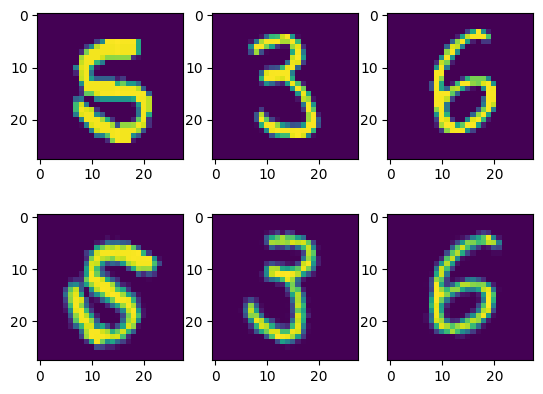

In [8]:
images, labels = next(iter(ds_train))
images = images.numpy()
labels = labels.numpy()
augmented_images = data_augmentation(images).numpy()
fig, ax = plt.subplots(nrows=2, ncols=3)

for i in range(ax.shape[1]):
    ax[0,i].imshow(images[i])
    ax[1,i].imshow(augmented_images[i])


# Data drift detection 

A significance level of $\alpha = 0.05$ is set to perform the hypothesis test.


In [9]:
alpha = 0.05

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a` imported from Frouros is used with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, p-value is estimated using permutation test.

In [10]:
detector = MMD(
    kernel=partial(rbf_kernel, sigma=0.5),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=100,
            num_jobs=-1,
            random_state=31,
            verbose=True,
            name="permutation_test",
        )
    ]
)
_ = detector.fit(X=images.reshape(images.shape[0], -1))

Perform the hypothesis test using the fitted detector and the augmented images.

In [11]:
result, callbacks_log = detector.compare(X=augmented_images.reshape(images.shape[0], -1))
p_value = callbacks_log["permutation_test"]["p_value"]
print(f"MMD statistic={round(result.distance, 3)}, p-value={round(p_value, 3)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

100%|██████████| 100/100 [00:00<00:00, 179.70it/s]


MMD statistic=-0.001, p-value=1.0
No drift detected. We fail to reject H0, so both samples come from the same distribution.
